## Import библиотек

In [ ]:
!pip install tensorflow==2.3.0
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)
print(tf.keras.__version__)
HOME = f'/content/drive/MyDrive/Python/fool_game/data/'
import os

2.3.0
2.4.0


In [ ]:
import collections

import numpy as np # импортируем библиотеку для работы с массивами данных
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, RMSprop# из кераса загружаем выбранный оптимизатор
import time                                # модуль для операций со временными характеристиками
import matplotlib.pyplot as plt            # импортируем библиотеку для визуализации данных
import seaborn as sns
import matplotlib
import pandas as pd
import pickle as pkl
import sys

# import cv2
# import collections
# import gym        
# import gym.spaces
from datetime import datetime, timedelta
from IPython.display import clear_output 

import pytz
timezone = pytz.timezone("Europe/Moscow")
# # "магическая" команда python для запуска библиотеки в ноутбуке
# %matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

### GYM Env

In [ ]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(np.moveaxis(old_space.low.repeat(n_steps, axis=0), 0, -1),
                                                np.moveaxis(old_space.high.repeat(n_steps, axis=0), 0, -1), dtype=dtype)
        pass

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        observation = np.moveaxis(observation, 0, 2)
        self.buffer = np.append(self.buffer, observation, axis=-1)
        self.buffer = np.delete(self.buffer, 0, axis=-1)
        return self.buffer


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        # print('old_shape', old_shape)
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], 
                                old_shape[0], old_shape[1]), dtype=np.float32)
        # self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape), dtype=np.float32)
        

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)
        # return observation


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

In [ ]:
num_actions = 4

def create_q_model(num_actions=4):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


In [ ]:
env = make_env('Pong-v0')
# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model(num_actions)
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model(num_actions)


### Experience buffer

In [ ]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

    def save(self, file_path, buff_len=10000):
        with open(file_path, "wb") as f:
            print('Save exp buffer...')
            if (len(self.buffer) < self.capacity) and (len(self.buffer) < buff_len):
              buff_len = len(self.buffer)
            elif len(self.buffer) < buff_len:
              buff_len = len(self.buffer)
            states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in range(len(self.buffer)-buff_len, len(self.buffer))])
            pkl.dump([states, actions, rewards, dones, next_states], f)
            del [states, actions, rewards, dones, next_states]
            pass

    def load(self, file_path):
        with open(file_path, "rb") as f:
            print('Loading exp buffer...')
            # self.buffer = pkl.load(f)
            states, actions, rewards, dones, next_states = pkl.load(f)
            for state, action, reward, done, next_state in zip(states, actions, rewards, dones, next_states):
                exp = Experience(state, action, reward, done, next_state)
                self.buffer.append(exp)
            del [states, actions, rewards, dones, next_states]
        pass 

### Agent

In [ ]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        # print(self.state.shape)
        self.total_reward = 0.0

    def play_step(self, model, epsilon=0.0):

        done_reward = None
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            # Predict action Q-values
            # From environment state
            state_a = np.array(self.state, copy=False)
            state_tensor = tf.convert_to_tensor(state_a)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

### Network

In [ ]:
num_actions = 4

def create_q_model(num_actions=4):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


### Figshow

In [ ]:
def figshow(df):
    fig = plt.figure(figsize=(26, 7))
    sns.set_style("white")
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_axisbelow(True)
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    # last_game = int(df["game"].max())
    # N = np.arange(0, last_game+1)

    plt.plot(df["game"], df["loss"], linestyle='--', color='blue', label="loss")
    plt.plot(df["game"], df["epsilon"], linestyle='--', color='green', label="epsilon")
    plt.title(f"Loss & epsilon")
    plt.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_axisbelow(True)
    ax2.minorticks_on()
    ax2.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.plot(df["game"], df['mean_reward'], linestyle='-', color='red', label="best_mean_reward")
    plt.plot(df["game"], df["time"]/10, linestyle='--', color='green', label="time/10")
    plt.title(f"mean_reward & time/10")
    plt.legend()
    plt.show()
    pass

In [ ]:
!nvidia-smi

Mon Feb  8 12:32:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    39W / 300W |    469MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
MEAN_REWARD_BOUND = 19.0           

gamma = 0.99                                   
batch_size = 32                 # at epoch = 1000
replay_size = 12000                
       
sync_target_frames = 1000       # at epoch = 1000 changed from 2000 to 3000
replay_start_size = 12000      
eps_start = 1.0
eps_decay = .999985          #changed from .9999935 to .9999999935
eps_min = 0.02                  # changed from 0.02 to 0.07 and at epoch=1000 to 0.1
buffer = ExperienceReplay(replay_size)

Loaded /content/drive/MyDrive/Colab Notebooks/data/dz32/q-deep/q_deep_model_weights_2100.h5 save, for model & model_target. Starting training from 2100


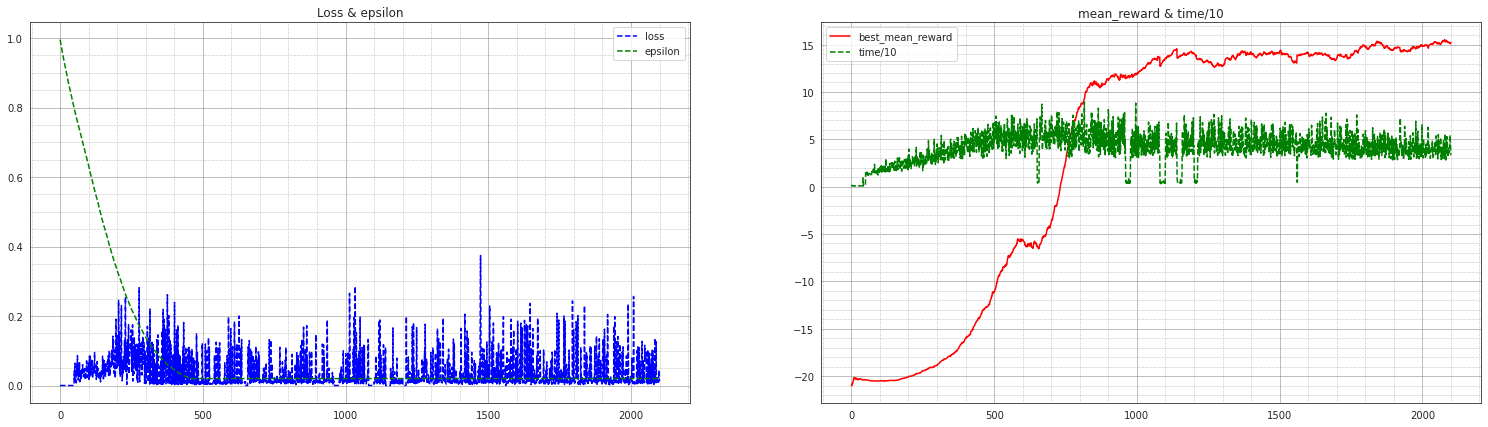

        game     frames       time      loss  epsilon  mean_reward
2086  2086.0  1692017.0  52.783396  0.029415     0.02        15.36
2087  2087.0  1692981.0  48.105319  0.032224     0.02        15.31
2088  2088.0  1693875.0  44.382290  0.125903     0.02        15.26
2089  2089.0  1694655.0  39.135350  0.021580     0.02        15.21
2090  2090.0  1695290.0  31.450918  0.008248     0.02        15.27
2091  2091.0  1696119.0  41.182275  0.012669     0.02        15.23
2092  2092.0  1696795.0  33.646597  0.022928     0.02        15.25
2093  2093.0  1697538.0  36.836635  0.012406     0.02        15.20
2094  2094.0  1698300.0  37.734825  0.008634     0.02        15.18
2095  2095.0  1699018.0  36.218855  0.015012     0.02        15.17
2096  2096.0  1699793.0  38.016402  0.009261     0.02        15.22
2097  2097.0  1700852.0  54.435878  0.013099     0.02        15.13
2098  2098.0  1701738.0  46.524602  0.043810     0.02        15.09
2099  2099.0  1702479.0  36.916049  0.013874     0.02        1

In [ ]:
model_weights_save_name = 'q_deep_model_weights'
history_csv_name = 'q_deep_model.csv'
exp_pkl_name = 'q_deep_model_exp.pkl'
cols = ['game',
        'frames',  
        'time', 
        'loss',
        'epsilon',
        'mean_reward',
       ]

def get_pd_data(pdfile):
  df_data = pd.read_csv(os.path.join(HOME, pdfile), index_col=0)
  return df_data

def add_data_to_pd(df_data, _game, _frames, _time, _loss, _epsilon, _mean_reward):
  df_data = df_data.append({'game': _game,
                            'frames': _frames,
                            'time': _time,
                            'loss': _loss,
                            'epsilon': _epsilon,
                            'mean_reward': _mean_reward,
                            }, ignore_index=True)
  # print(self.df.to_string())
  return df_data
  
def load_checkpoint(save_name):
    pd_file_path =  os.path.join(HOME, history_csv_name)
    if os.path.exists(pd_file_path):    
      df = get_pd_data(pd_file_path)
      pd_start_game= int(df.game.max())
    else:
      pd_start_game = 0
      df = pd.DataFrame(columns=cols)
    start_game = 0
    mean_reward = 0
    dirlist = os.listdir(HOME)
    for i in range (len(dirlist)):
      filename = dirlist[i]
      if save_name in filename:
        if '_' in filename: 
          try: 
            epoch = int((filename.split('_')[-1]).split('.')[-2])
          except ValueError:
            epoch = 0
          if epoch > start_game:
            start_game = epoch
    if pd_start_game > start_game:
      df.drop(index = [i for i in range(start_game+1, pd_start_game+1)], axis=0, inplace=True)
      # df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
    if start_game > 0:
      file_path = os.path.join(HOME, f'{save_name}_{start_game}.h5')
      model.load_weights(file_path)
      model_target.load_weights(file_path)
      print(f"Loaded {file_path} save, for model & model_target. Starting training from {start_game}")
      # last epoch +1
      epsilon = float(df.loc[(df["game"]==start_game), "epsilon"].item())
      mean_reward = float(df.loc[(df["game"]==start_game), "mean_reward"].item())
    else:
      epsilon = 1.0
      print(f"Starting from scratches. Starting game = {start_game}")
    return df, start_game, epsilon, mean_reward

df, start_game, epsilon, mean_reward = load_checkpoint(model_weights_save_name)

if start_game != 0:
  frame_idx = int(df.frames.max())
  figshow(df)
  game = start_game
  total_rewards = []
  total_rewards = df.loc[(df["game"]<=start_game) &(df["game"]>=start_game-100), "mean_reward"].values.tolist()
  # epsilon = 0.1
  learning_rate = 0.00025
  adam_hat = 1e-8
  if game > 200:
    lr_decay = 60/game
    learning_rate = learning_rate * lr_decay
    if learning_rate < adam_hat:
      learning_rate = adam_hat
else:
  frame_idx = 0
  mean_reward = 0
  game = -1
  epsilon = eps_start
  total_rewards = []
  learning_rate = 0.00025   

print(df.tail(15).to_string())
print(f'Start game:', start_game)
print('Frame index:', frame_idx)
print('Epsilon:', epsilon)
print('Learning rate:', learning_rate)
print('Mean reward on last game:', mean_reward)
print('_mean_ of Total rewards for last 100 games:', np.mean(total_rewards[-100:]))

exp_file_path = os.path.join(HOME, f'{exp_pkl_name}')
if start_game != 0:
  if os.path.exists(exp_file_path):
    buffer.load(exp_file_path)
  else:
    msg = f"Warning: pickle Exp file not found, starting without" 
    print(msg)

time_sum = int(df["time"].sum())
print(f'Model learning {start_game} games and {timedelta(seconds=time_sum)}')

>>>Training starts at  2021-02-08 07:23:35.710564+03:00
game: 1561, frame_idx: 1262224, epsilon: 0.02, mean reward: 13.895, loss: 0.0000. Best mean reward updated 13.895, time: 8.1313 sec
game: 1562, frame_idx: 1263082, epsilon: 0.02, mean reward: 13.885, loss: 0.0000, time: 4.5350 sec
game: 1563, frame_idx: 1264157, epsilon: 0.02, mean reward: 13.853, loss: 0.0000, time: 38.4009 sec
game: 1564, frame_idx: 1265024, epsilon: 0.02, mean reward: 13.853, loss: 0.0063, time: 45.9005 sec
game: 1565, frame_idx: 1265919, epsilon: 0.02, mean reward: 13.822, loss: 0.0152, time: 47.4117 sec
game: 1566, frame_idx: 1266603, epsilon: 0.02, mean reward: 13.832, loss: 0.0919, time: 36.4434 sec
game: 1567, frame_idx: 1267374, epsilon: 0.02, mean reward: 13.851, loss: 0.0956, time: 40.9508 sec
game: 1568, frame_idx: 1267995, epsilon: 0.02, mean reward: 13.900, loss: 0.0111. Best mean reward updated 13.900, time: 33.4780 sec
game: 1569, frame_idx: 1268593, epsilon: 0.02, mean reward: 13.968, loss: 0.0087

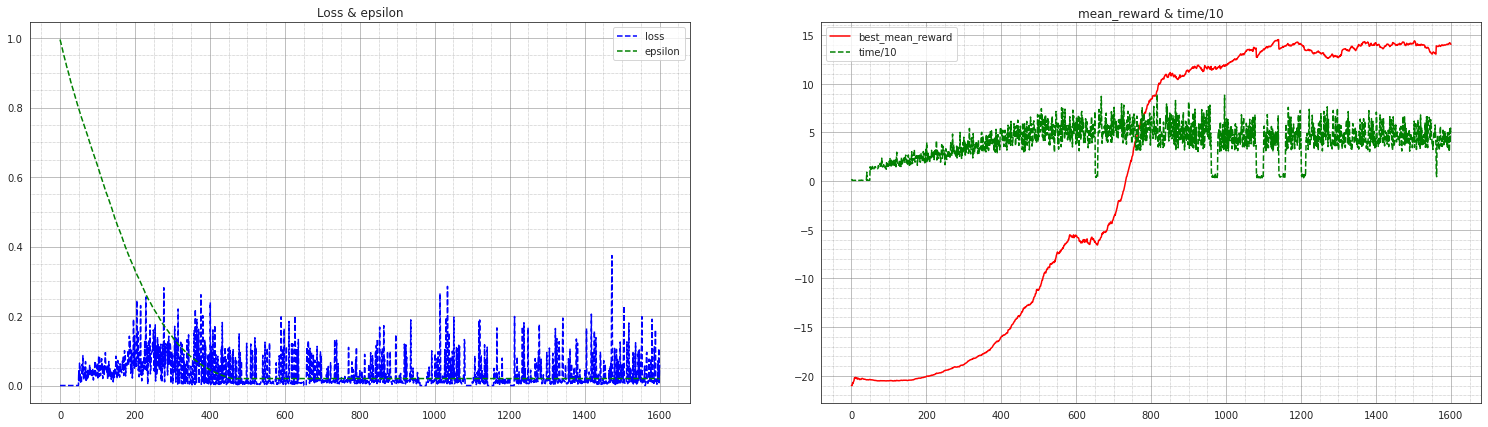

game: 1601, frame_idx: 1294777, epsilon: 0.02, mean reward: 14.089, loss: 0.0600, time: 43.3212 sec
game: 1602, frame_idx: 1295933, epsilon: 0.02, mean reward: 13.905, loss: 0.0124, time: 61.0411 sec
game: 1603, frame_idx: 1297078, epsilon: 0.02, mean reward: 13.791, loss: 0.0150, time: 60.8075 sec
game: 1604, frame_idx: 1298035, epsilon: 0.02, mean reward: 13.738, loss: 0.1853, time: 50.5020 sec
game: 1605, frame_idx: 1298823, epsilon: 0.02, mean reward: 13.765, loss: 0.0133, time: 41.6554 sec
game: 1606, frame_idx: 1299585, epsilon: 0.02, mean reward: 13.803, loss: 0.0125, time: 40.6022 sec
game: 1607, frame_idx: 1300394, epsilon: 0.02, mean reward: 13.824, loss: 0.0120, time: 43.6123 sec
game: 1608, frame_idx: 1301193, epsilon: 0.02, mean reward: 13.854, loss: 0.0087, time: 43.0660 sec
game: 1609, frame_idx: 1301881, epsilon: 0.02, mean reward: 13.894, loss: 0.0468, time: 36.4950 sec
game: 1610, frame_idx: 1302503, epsilon: 0.02, mean reward: 13.954, loss: 0.0055, time: 33.0731 sec


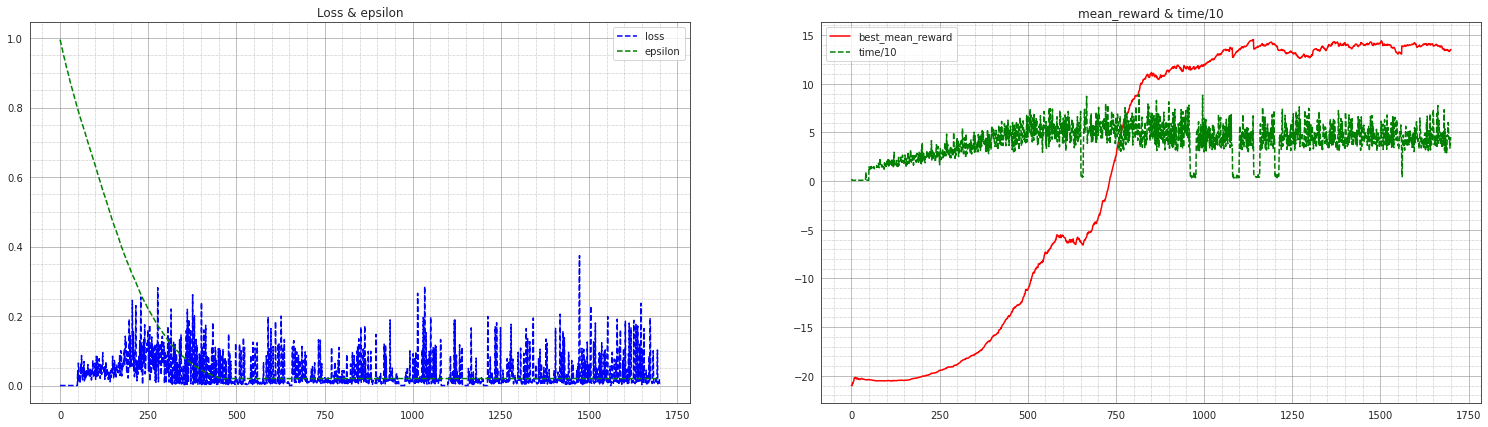

game: 1701, frame_idx: 1379533, epsilon: 0.02, mean reward: 13.560, loss: 0.0048, time: 39.8314 sec
game: 1702, frame_idx: 1380264, epsilon: 0.02, mean reward: 13.780, loss: 0.0422, time: 39.7337 sec
game: 1703, frame_idx: 1381521, epsilon: 0.02, mean reward: 13.830, loss: 0.0351, time: 67.1794 sec
game: 1704, frame_idx: 1382408, epsilon: 0.02, mean reward: 13.900, loss: 0.0097, time: 46.9929 sec
game: 1705, frame_idx: 1383367, epsilon: 0.02, mean reward: 13.860, loss: 0.0109, time: 50.6508 sec
game: 1706, frame_idx: 1383915, epsilon: 0.02, mean reward: 13.890, loss: 0.0682, time: 28.8420 sec
game: 1707, frame_idx: 1384800, epsilon: 0.02, mean reward: 13.910, loss: 0.0107, time: 46.7819 sec
game: 1708, frame_idx: 1385579, epsilon: 0.02, mean reward: 13.890, loss: 0.0106, time: 41.2646 sec
game: 1709, frame_idx: 1386281, epsilon: 0.02, mean reward: 13.870, loss: 0.0184, time: 37.0292 sec
game: 1710, frame_idx: 1386926, epsilon: 0.02, mean reward: 13.870, loss: 0.0143, time: 33.8195 sec


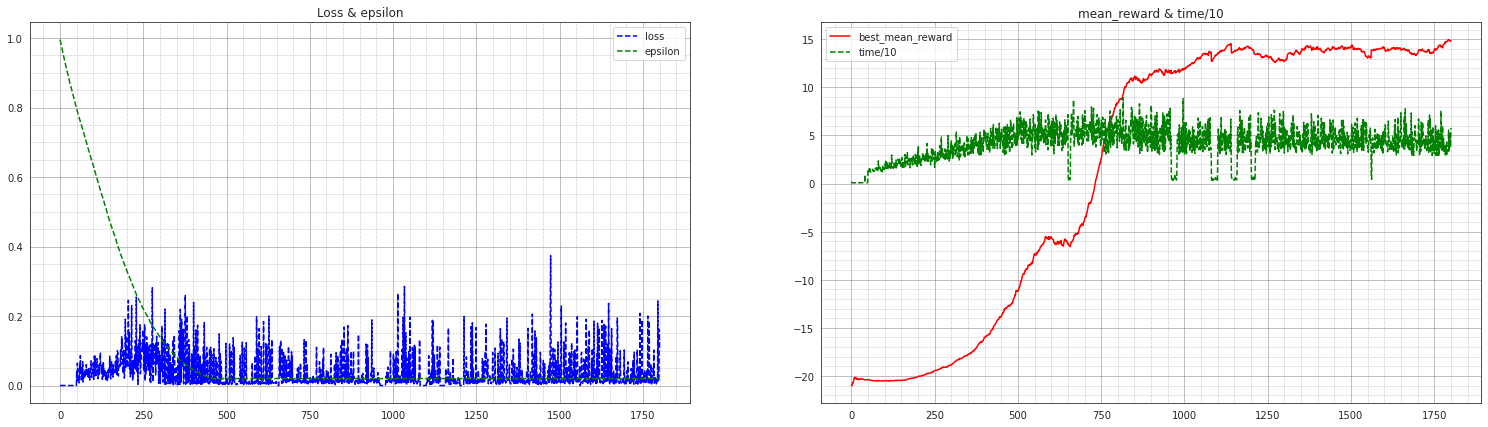

game: 1801, frame_idx: 1462695, epsilon: 0.02, mean reward: 14.720, loss: 0.1108, time: 59.1616 sec
game: 1802, frame_idx: 1463592, epsilon: 0.02, mean reward: 14.660, loss: 0.0183, time: 46.4735 sec
game: 1803, frame_idx: 1464495, epsilon: 0.02, mean reward: 14.720, loss: 0.0038, time: 46.7134 sec
game: 1804, frame_idx: 1465117, epsilon: 0.02, mean reward: 14.760, loss: 0.0125, time: 32.6132 sec
game: 1805, frame_idx: 1466083, epsilon: 0.02, mean reward: 14.720, loss: 0.0094, time: 50.4530 sec
game: 1806, frame_idx: 1467084, epsilon: 0.02, mean reward: 14.590, loss: 0.0146, time: 51.7027 sec
game: 1807, frame_idx: 1467902, epsilon: 0.02, mean reward: 14.550, loss: 0.0169, time: 43.1798 sec
game: 1808, frame_idx: 1468757, epsilon: 0.02, mean reward: 14.540, loss: 0.0167, time: 43.9224 sec
game: 1809, frame_idx: 1469363, epsilon: 0.02, mean reward: 14.580, loss: 0.1842, time: 31.3892 sec
game: 1810, frame_idx: 1470311, epsilon: 0.02, mean reward: 14.500, loss: 0.0810, time: 49.0741 sec


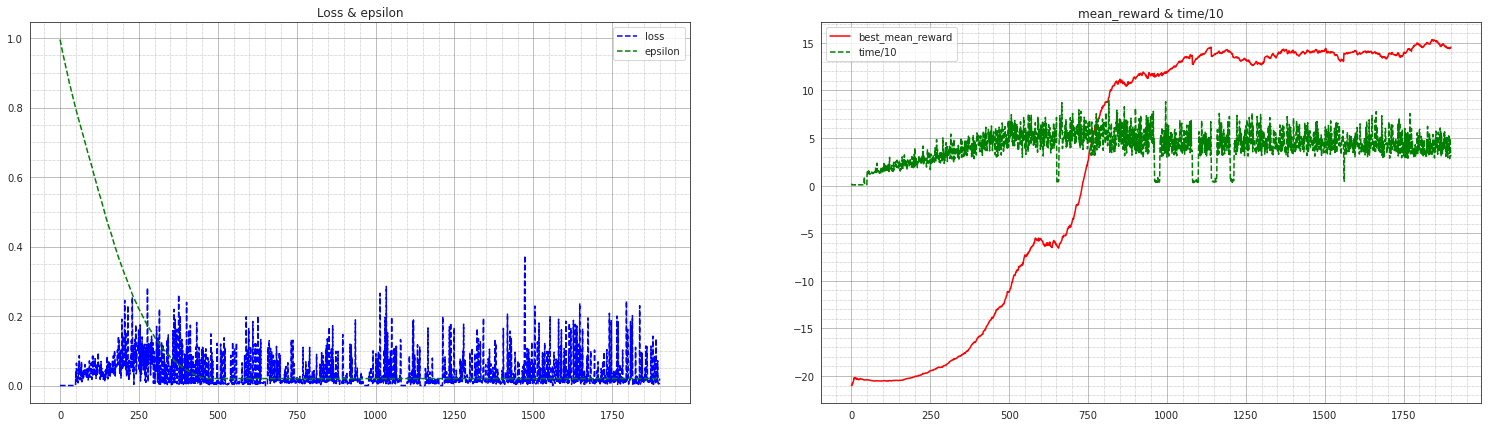

game: 1901, frame_idx: 1543819, epsilon: 0.02, mean reward: 14.550, loss: 0.0201, time: 50.6428 sec
game: 1902, frame_idx: 1544408, epsilon: 0.02, mean reward: 14.620, loss: 0.1331, time: 30.1525 sec
game: 1903, frame_idx: 1544967, epsilon: 0.02, mean reward: 14.690, loss: 0.1270, time: 28.6047 sec
game: 1904, frame_idx: 1545871, epsilon: 0.02, mean reward: 14.610, loss: 0.0651, time: 46.2868 sec
game: 1905, frame_idx: 1546780, epsilon: 0.02, mean reward: 14.650, loss: 0.0126, time: 46.4499 sec
game: 1906, frame_idx: 1547683, epsilon: 0.02, mean reward: 14.690, loss: 0.1324, time: 45.9934 sec
game: 1907, frame_idx: 1548478, epsilon: 0.02, mean reward: 14.690, loss: 0.0064, time: 40.0290 sec
game: 1908, frame_idx: 1549494, epsilon: 0.02, mean reward: 14.650, loss: 0.1623, time: 52.1491 sec
game: 1909, frame_idx: 1550157, epsilon: 0.02, mean reward: 14.620, loss: 0.1103, time: 33.8586 sec
game: 1910, frame_idx: 1550787, epsilon: 0.02, mean reward: 14.680, loss: 0.0070, time: 31.8517 sec


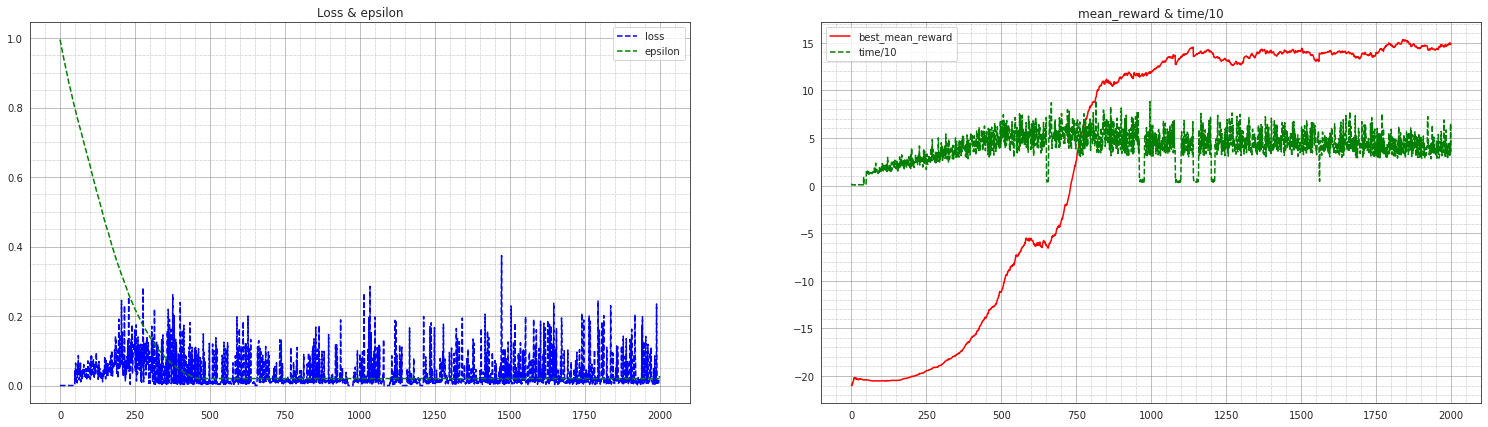

game: 2001, frame_idx: 1624196, epsilon: 0.02, mean reward: 14.900, loss: 0.0269, time: 35.1722 sec
game: 2002, frame_idx: 1625074, epsilon: 0.02, mean reward: 14.860, loss: 0.0251, time: 44.0654 sec
game: 2003, frame_idx: 1625676, epsilon: 0.02, mean reward: 14.850, loss: 0.0118, time: 30.2751 sec
game: 2004, frame_idx: 1626672, epsilon: 0.02, mean reward: 14.830, loss: 0.0789, time: 50.8020 sec
game: 2005, frame_idx: 1627487, epsilon: 0.02, mean reward: 14.830, loss: 0.0254, time: 41.3681 sec
game: 2006, frame_idx: 1628231, epsilon: 0.02, mean reward: 14.880, loss: 0.0266, time: 37.7357 sec
game: 2007, frame_idx: 1628995, epsilon: 0.02, mean reward: 14.870, loss: 0.0056, time: 39.0189 sec
game: 2008, frame_idx: 1629677, epsilon: 0.02, mean reward: 14.960, loss: 0.0058, time: 34.5570 sec
game: 2009, frame_idx: 1630411, epsilon: 0.02, mean reward: 14.940, loss: 0.0305, time: 37.0674 sec
game: 2010, frame_idx: 1631196, epsilon: 0.02, mean reward: 14.920, loss: 0.2564, time: 39.5961 sec


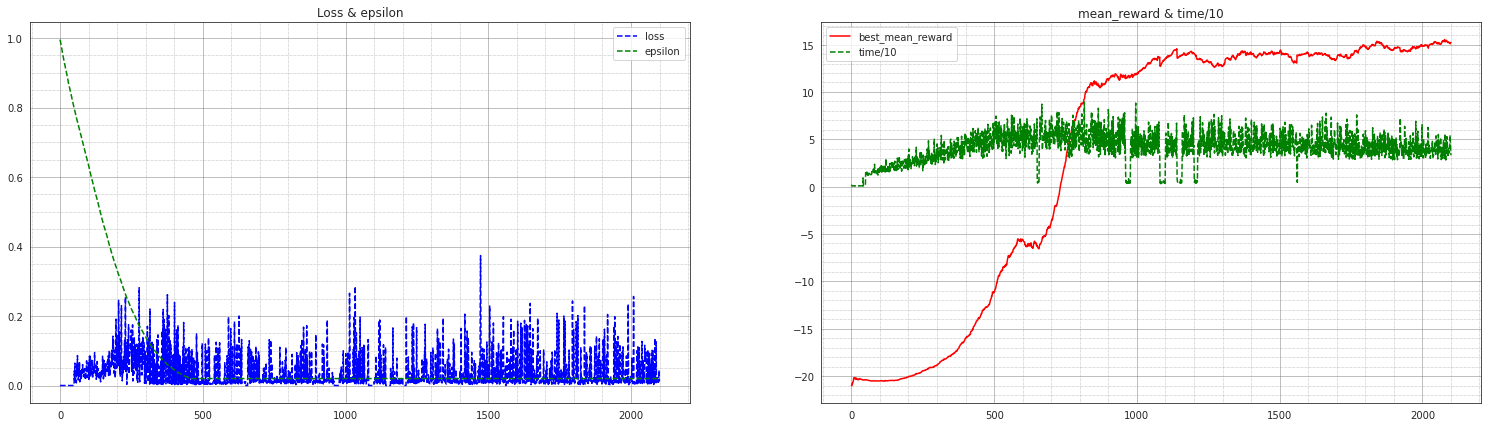

game: 2101, frame_idx: 1703811, epsilon: 0.02, mean reward: 15.230, loss: 0.0121, time: 41.2742 sec
game: 2102, frame_idx: 1704575, epsilon: 0.02, mean reward: 15.210, loss: 0.0068, time: 38.6399 sec
game: 2103, frame_idx: 1705479, epsilon: 0.02, mean reward: 15.150, loss: 0.1830, time: 45.4367 sec
game: 2104, frame_idx: 1706438, epsilon: 0.02, mean reward: 15.180, loss: 0.0039, time: 48.3799 sec
game: 2105, frame_idx: 1707973, epsilon: 0.02, mean reward: 15.070, loss: 0.0979, time: 76.9382 sec
game: 2106, frame_idx: 1709103, epsilon: 0.02, mean reward: 14.980, loss: 0.0198, time: 56.5262 sec
game: 2107, frame_idx: 1709809, epsilon: 0.02, mean reward: 15.030, loss: 0.0075, time: 34.8185 sec
game: 2108, frame_idx: 1710451, epsilon: 0.02, mean reward: 15.030, loss: 0.0179, time: 31.8097 sec
game: 2109, frame_idx: 1711119, epsilon: 0.02, mean reward: 15.070, loss: 0.1402, time: 32.9078 sec
game: 2110, frame_idx: 1712546, epsilon: 0.02, mean reward: 14.950, loss: 0.0867, time: 70.2829 sec


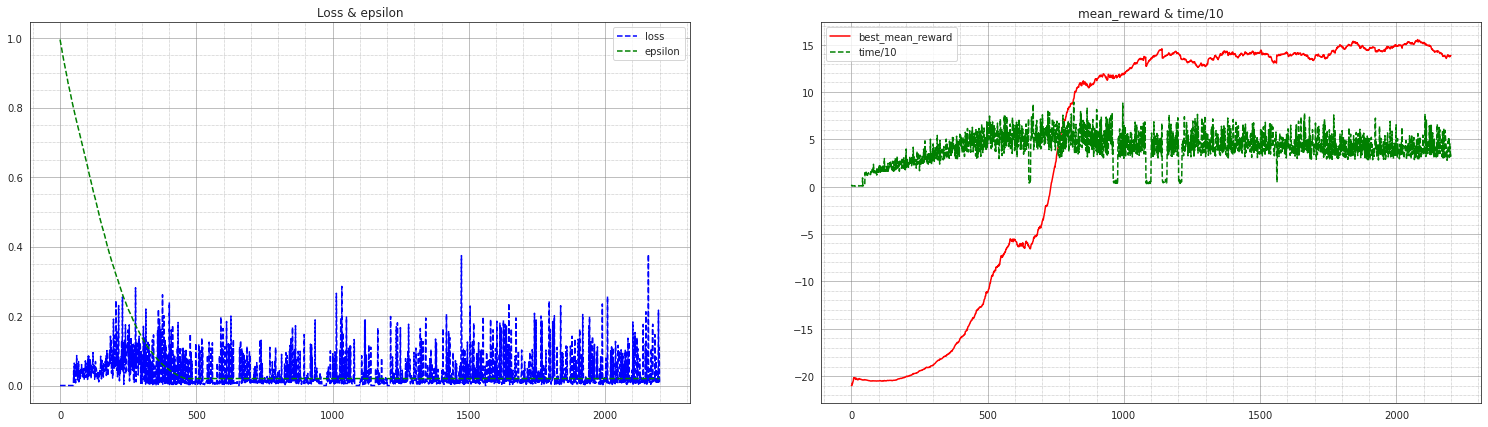

game: 2201, frame_idx: 1790207, epsilon: 0.02, mean reward: 13.770, loss: 0.0029, time: 45.5660 sec
game: 2202, frame_idx: 1790785, epsilon: 0.02, mean reward: 13.840, loss: 0.0179, time: 28.9344 sec
game: 2203, frame_idx: 1791488, epsilon: 0.02, mean reward: 13.880, loss: 0.0124, time: 35.4581 sec
game: 2204, frame_idx: 1792130, epsilon: 0.02, mean reward: 13.950, loss: 0.0048, time: 32.3000 sec
game: 2205, frame_idx: 1793187, epsilon: 0.02, mean reward: 14.020, loss: 0.1266, time: 55.0383 sec
game: 2206, frame_idx: 1793784, epsilon: 0.02, mean reward: 14.140, loss: 0.0567, time: 30.6763 sec
game: 2207, frame_idx: 1794824, epsilon: 0.02, mean reward: 14.080, loss: 0.0107, time: 53.7688 sec
game: 2208, frame_idx: 1795438, epsilon: 0.02, mean reward: 14.090, loss: 0.0136, time: 31.5911 sec
game: 2209, frame_idx: 1796685, epsilon: 0.02, mean reward: 13.870, loss: 0.0653, time: 61.5572 sec
game: 2210, frame_idx: 1797443, epsilon: 0.02, mean reward: 13.970, loss: 0.0132, time: 36.8884 sec


KeyboardInterrupt: ignored

In [ ]:
# optimizer = keras.optimizers.Adam(learning_rate=0.00025) # added back clipnorm (was deleted)
# loss_funct = tf.keras.losses.Huber(delta=1.2)   # changet at epoch 1100 from 1.3
# optimizer = keras.optimizers.Adam(learning_rate=learning_rate) # added back clipnorm (was deleted)
# optimizer = keras.optimizers.SGD(learning_rate=learning_rate,
#                                   momentum=0.9,
#                                   nesterov=True) # added back clipnorm (was deleted
optimizer = Adam(learning_rate=learning_rate)
loss_funct = tf.keras.losses.Huber(delta=1.5)   # changet at epoch 1100 from 1.3

# optimizer = Adam(lr=learning_rate)
# loss_funct = tf.keras.losses.Huber()

# model.compile(optimizer = optimizer,
#               loss = loss_funct,
#               metrics=['mean_square_error'])

# model_target.compile(optimizer = optimizer,
#                     loss = loss_funct,
#                     metrics=['mean_square_error'])

agent = Agent(env, buffer)

best_mean_reward = None
num_actions = 4
loss_numpy = 0
loss = 0

start_datetime = datetime.now(timezone)
print(">>>Training starts at ", start_datetime)
startTime = time.time()
while True:
        frame_idx += 1
        epsilon = max(epsilon*eps_decay, eps_min)
        reward = agent.play_step(model, epsilon)
        if reward is not None:
            game += 1
            total_rewards.append(reward)
            mean_reward = np.mean(total_rewards[-100:])
            if len(total_rewards) > 100:
              del total_rewards[:1]
            msg = f"\rgame: {game}, frame_idx: {frame_idx}, epsilon: {epsilon:.2f}"
            msg = f"{msg}, mean reward: {mean_reward:.3f}, loss: {loss_numpy:.4f}"
         
            if best_mean_reward is None or best_mean_reward < mean_reward:
                best_mean_reward = mean_reward
                if best_mean_reward is not None:
                    msg = f'{msg}. Best mean reward updated {best_mean_reward:.3f}'

            if mean_reward > MEAN_REWARD_BOUND:
                endTime = time.time()
                game_time = endTime - startTime
                startTime = time.time()
                print(f'{msg}, time: {game_time:.4f} sec')    
                print("Solved in %d frames!" % frame_idx)
                if tf.is_tensor(loss):
                   loss_numpy = tf.keras.backend.get_value(loss)
                df = add_data_to_pd(df, game, frame_idx, game_time, loss_numpy, epsilon, mean_reward)
                df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
                break
            
            if tf.is_tensor(loss):
                loss_numpy = tf.keras.backend.get_value(loss)    

            endTime = time.time()
            game_time = endTime - startTime
            startTime = time.time()
            print(f'{msg}, time: {game_time:.4f} sec')
            df = add_data_to_pd(df, game, frame_idx, game_time, loss_numpy, epsilon, mean_reward)
            if (game % 10 == 0) and (game != 0):
                df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
            if (game % 60 == 0) and (game != 0) and (frame_idx >= replay_start_size):
                print('Saving weights...')
                model.save_weights(os.path.join(HOME, f'{model_weights_save_name}_{game:002d}.h5'))
                buffer.save(exp_file_path, 10000)
            if game % 100 == 0:
                figshow(df)
            elif (game % 500 == 0) and (game != 0):  
                clear_output()
                print(df.tail(50).to_string())
                figshow(df)

        if len(buffer) < replay_start_size:
            continue

        batch = buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = batch

        # Build the updated Q-values for the sampled future states
        # Use the target model for stability
        future_rewards = model_target.predict(next_states)
        # Q value = reward + discount factor * expected future reward
        updated_q_values = rewards + gamma * tf.reduce_max(
            future_rewards, axis=1
        )

        # If final frame set the last value to -1
        updated_q_values = updated_q_values * (1 - dones) - dones

        # Create a mask so we only calculate loss on the updated Q-values
        masks = tf.one_hot(actions, num_actions)

        with tf.GradientTape() as tape:
            # Train the model on the states and updated Q-values
            q_values = model(states)

            # Apply the masks to the Q-values to get the Q-value for action taken
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            # Calculate loss between new Q-value and old Q-value
            loss = loss_funct(updated_q_values, q_action)

        # Backpropagation
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_idx % sync_target_frames == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())

print('Saving weights...')
model.save_weights(os.path.join(HOME, f'{model_weights_save_name}_{game:002d}.h5'))
buffer.save(exp_file_path)
figshow(df)

end_datetime = datetime.now(timezone)
print(">>>Training ends at ", end_datetime)
train_time = start_datetime-end_datetime
print(f'Model trained:', timedelta(hours=train_time))


## Сыграем эпизод обученной моделью и воспроизведем видео

In [ ]:
from datetime import datetime, timedelta
from IPython.display import clear_output 

num_actions = 4
model_weights_save_name = 'q_deep_model_weights'
optimizer = Adam(lr=0.0001)
loss_funct = tf.keras.losses.Huber()

model = create_q_model(num_actions)

model.compile(optimizer = optimizer,
              loss = loss_funct,
              metrics=['mean_absolute_error'])
 
def load_checkpoint(model, save_name):
    start_game = 0
    dirlist = os.listdir(HOME)
    for i in range (len(dirlist)):
      filename = dirlist[i]
      if save_name in filename:
        if '_' in filename: 
          try: 
            epoch = int((filename.split('_')[-1]).split('.')[-2])
          except ValueError:
            epoch = 0
          if epoch > start_game:
            start_game = epoch

    if start_game > 0:
      file_path = os.path.join(HOME, f'{save_name}_{start_game}.h5')
      
      model.load_weights(file_path)
      print(f"Loaded {file_path} save. Last game {start_game}")
      # last epoch +1
    else:
      print(f"Weights not found!")
    return model, start_game

model, start_game = load_checkpoint(model, model_weights_save_name)

Loaded /content/drive/MyDrive/Colab Notebooks/data/dz32/q-deep/q_deep_model_weights_2100.h5 save. Last game 2100


In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой
 
# from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = gym.wrappers.Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
DEFAULT_ENV_NAME ='Pong-v0'
def play_episode(model): # подаем на вход функции модель нейросети
    FPS = 25
    env = make_env(DEFAULT_ENV_NAME)
    env = wrapEnv(env)              # создаем среду в режиме записи
    
    done = False                       # игровой эпизод не завершён
    # observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    # newObservation = observation       # задали новое состояние которое наблюдает агент
    state = env.reset()
    total_reward = 0.0
    while done == False:               # пока игровой эпизод не завершён
        start_ts = time.time()
        env.render() 
        state_a = np.array(state, copy=False)
        state_tensor = tf.convert_to_tensor(state_a)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model.predict(state_tensor)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()

        state, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break
        delta = 1/FPS - (time.time() - start_ts)
        if delta > 0:
            time.sleep(delta)
        # env.render()                   # запускаем воспроизведение среды
    env.close() # закрываем игровую среду после окончания игры
    print(f'Total reward: {total_reward:.2f}')
    showVideo() # показать видео игры

In [ ]:
# Взглянем как сыграет сетка, обученная на 1910 тренировках
# model.load_weights(os.path.join(HOME, f'{model_weights_save_name}_1140.h5')) # подгружаем модель из сохранённых
play_episode(model)                     # запускаем игровой эпизод

Total reward: 17.00
